<div class="usecase-title">Enhancing Community Well-being Through Public Transport Accessibility</div>

<div class="usecase-authors"><b>Authored by: </b> Sai Priyamvada</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, matpotlib,numpy, Data Science, Geospatial Analysis</div>
</div>

<div class="usecase-section-header">Scenario</div>

1.As a public health researcher, I want to analyze the impact of public transport accessibility on the health and well-being of Melbourne residents.

Public transport can significantly influence people's access to health services, social connections, and overall quality of life. This analysis aims to identify how proximity to bus and tram stops correlates with various well-being indicators, such as physical and mental health.

2.As a city planner, I want to understand the relationship between public transport access and community participation.

Community participation can be facilitated by convenient public transport options, allowing residents to engage in social activities, work, and leisure. This analysis will help in planning public transport routes to enhance community connectivity.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
Learn how to import and integrate data from multiple sources, including survey data and geospatial data.
Understand methods for geocoding and calculating distances between locations.
Gain skills in analyzing and visualizing the relationship between public transport accessibility and community well-being indicators.
Be able to present findings that can influence public policy and urban planning decisions.

<div class="usecase-section-header">Introduction or background relating to problem</div>

Public transport plays a crucial role in urban settings, offering accessibility and mobility to residents. For a city like Melbourne, which is known for its high quality of life, understanding the role of public transport in enhancing community well-being is vital. This analysis seeks to explore how close proximity to bus and tram stops influences residents' physical health, mental well-being, social connections, and participation in community activities.

Key Factors of Analysis

Physical Health: How does public transport accessibility impact access to healthcare services and physical activity levels?
Mental Well-being: Is there a correlation between easy access to public transport and reduced stress or improved mental health?
Community Participation: Does proximity to public transport encourage participation in social and community activities?
Social Connectedness: How does public transport influence social interactions and connections?

DATASETS :

Dataset 1: https://data.melbourne.vic.gov.au/explore/dataset/social-indicators-for-city-of-melbourne-residents-2023/information/
Title: Social Indicators for City of Melbourne Residents 2023 (CoMSIS)
Source: City of Melbourne Open Data Portal
Description: This dataset provides comprehensive social and demographic data for Melbourne residents, including health, well-being, and transport-related information.

Dataset 2: https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/
Title: Bus Stops
Source: City of Melbourne Open Data Portal
Description: This dataset contains the location of bus stops within the city of Melbourne.

Dataset 3: : https://data.melbourne.vic.gov.au/explore/dataset/tram-tracks/export/
Title: Tram Stops
Source: City of Melbourne Open Data Portal
Description: This dataset contains the location of tram stops within the city of Melbourne.


1.importing required libraries

In [5]:
pip install pandas geopandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from io import StringIO
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from shapely.geometry import shape, Point
from bs4 import BeautifulSoup
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import time


A.Downloading the datsets through api
B.Converting datasets to DataFrames

In [2]:
def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': api_key
    }

    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024  
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:  
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            data = pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
            return data
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = ['tram-tracks', 'bus-stops', 'social-indicators-for-city-of-melbourne-residents-2023']

# Initialize dictionary to hold the datasets
datasets = {}

# Download each dataset with a progress bar
for dataset_id in dataset_ids:
    datasets[dataset_id] = download_dataset('', dataset_id)
    if datasets[dataset_id] is not None:
        print(f"{dataset_id} downloaded successfully.")

# Convert datasets to DataFrames
social_indicators_df = datasets['social-indicators-for-city-of-melbourne-residents-2023']#data set 1
bus_stops_df = datasets['bus-stops']#dataset 2
tram_tracks_df = datasets['tram-tracks']#dataset 3

tram-tracks downloaded successfully.


bus-stops downloaded successfully.


social-indicators-for-city-of-melbourne-residents-2023 downloaded successfully.


2.DATA CLEANING

Data set 1: Social Indicators Data Cleaning 
1.Remove duplicates: Checking for and removing any duplicate rows. 
2.Handle missing values: Identifying any missing values and deciding on an appropriate method to handle them (e.g., filling, removing). 
3.Ensure correct data types: Verifying that the data types of each column are appropriate.
4.Standardize text data: Ensureing that text data (e.g., columns with object dtype) is consistently formatted (e.g., lowercased, no trailing spaces).

In [3]:
social_indicators_df.head()
social_indicators_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   indicator         594 non-null    object 
 1   type              594 non-null    object 
 2   topic             594 non-null    object 
 3   description       594 non-null    object 
 4   response          594 non-null    object 
 5   respondent_group  594 non-null    object 
 6   year              594 non-null    int64  
 7   sample_size       594 non-null    int64  
 8   result            594 non-null    float64
 9   format            594 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 46.5+ KB


In [4]:
social_indicators_df.drop_duplicates(inplace=True)
missing_values = social_indicators_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 indicator           0
type                0
topic               0
description         0
response            0
respondent_group    0
year                0
sample_size         0
result              0
format              0
dtype: int64


In [5]:
print("Data types:\n", social_indicators_df.dtypes)

Data types:
 indicator            object
type                 object
topic                object
description          object
response             object
respondent_group     object
year                  int64
sample_size           int64
result              float64
format               object
dtype: object


In [6]:
columns_to_clean = ['indicator', 'type', 'topic', 'description', 'response', 'respondent_group', 'format']
for column in columns_to_clean:
    social_indicators_df[column] = social_indicators_df[column].str.strip().str.lower()

# Print the cleaned DataFrame
social_indicators_df.head(500)

,indicator,type,topic,description,response,respondent_group,year,sample_size,result,format
0,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,25-34 years,2023,419,17.1,per cent
1,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,45-54 years,2023,128,15.0,per cent
2,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,65+ years,2023,202,3.6,per cent
3,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,docklands 3008,2023,113,4.5,per cent
4,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,melbourne 3000,2023,338,18.0,per cent
...,...,...,...,...,...,...,...,...,...,...
495,6a,other,food security,worried food would run out,"yes, in the last 12 months",melbourne 3000,2023,341,25.1,per cent
496,6a,other,food security,worried food would run out,"yes, in the last 12 months",parkville 3052,2023,77,20.1,per cent
497,6a,other,food security,worried food would run out,"yes, in the last 12 months",south yarra 3141 / melbourne/st kilda road 3004,2023,138,28.2,per cent
498,6b,other,food security,skipped meals,"yes, in the last 12 months",18-24 years,2023,273,32.0,per cent


In [7]:
#differentiating the respondent_group and location as both are mixed in one column as observed in the previous output
# Creating new columns for age groups and locations
social_indicators_df['age_group'] = social_indicators_df['respondent_group'].apply(lambda x: x if 'years' in x else None)
social_indicators_df['location'] = social_indicators_df['respondent_group'].apply(lambda x: x if 'years' not in x else None)

# Dropping the original 'respondent_group' column if not needed
social_indicators_df.drop('respondent_group', axis=1, inplace=True)



In [8]:
social_indicators_df.head(500)

,indicator,type,topic,description,response,year,sample_size,result,format,age_group,location
0,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,419,17.1,per cent,25-34 years,None
1,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,128,15.0,per cent,45-54 years,None
2,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,202,3.6,per cent,65+ years,None
3,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,113,4.5,per cent,None,docklands 3008
4,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,338,18.0,per cent,None,melbourne 3000
...,...,...,...,...,...,...,...,...,...,...,...
495,6a,other,food security,worried food would run out,"yes, in the last 12 months",2023,341,25.1,per cent,None,melbourne 3000
496,6a,other,food security,worried food would run out,"yes, in the last 12 months",2023,77,20.1,per cent,None,parkville 3052
497,6a,other,food security,worried food would run out,"yes, in the last 12 months",2023,138,28.2,per cent,None,south yarra 3141 / melbourne/st kilda road 3004
498,6b,other,food security,skipped meals,"yes, in the last 12 months",2023,273,32.0,per cent,18-24 years,None


In [9]:
import pandas as pd
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="my_geocoder")

def get_lat_lon(address):
  try:
    location = geolocator.geocode(address)
    if location:
      return location.latitude, location.longitude
    else:
      return None, None
  except:
    return None, None

# Applied function to create new columns lat,long
social_indicators_df['latitude'], social_indicators_df['longitude'] = zip(*social_indicators_df['location'].apply(get_lat_lon))




In [50]:
# social_indicators_df.loc[social_indicators_df['location'].isnull(), ['latitude', 'longitude']] = None
social_indicators_df['latitude'].fillna(0, inplace=True)
social_indicators_df['longitude'].fillna(0, inplace=True)

social_indicators_df.head(594)

,indicator,type,topic,description,response,year,sample_size,result,format,age_group,location,latitude,longitude
0,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,419,17.1,per cent,25-34 years,None,0.000000,0.000000
1,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,128,15.0,per cent,45-54 years,None,0.000000,0.000000
2,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,202,3.6,per cent,65+ years,None,0.000000,0.000000
3,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,113,4.5,per cent,None,docklands 3008,-37.817542,144.939492
4,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,338,18.0,per cent,None,melbourne 3000,-37.814245,144.963173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,9,other,quality of life,satisfaction with life as a whole,average satisfaction score (from 0-100),2023,202,80.6,average,65+ years,None,0.000000,0.000000
590,9,other,quality of life,satisfaction with life as a whole,average satisfaction score (from 0-100),2023,192,69.3,average,None,carlton 3053,-37.800423,144.968434
591,9,other,quality of life,satisfaction with life as a whole,average satisfaction score (from 0-100),2023,1369,72.7,average,None,city of melbourne,-37.812382,144.948265
592,9,other,quality of life,satisfaction with life as a whole,average satisfaction score (from 0-100),2023,69,78.7,average,None,east melbourne 3002,-37.812498,144.985885


DATASET 2: BUS STOP DATASET

In [29]:
bus_stops_df.info()
bus_stops_df.head(300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  309 non-null    object 
 1   geo_shape     309 non-null    object 
 2   prop_id       309 non-null    int64  
 3   addresspt1    309 non-null    float64
 4   addressp_1    309 non-null    int64  
 5   asset_clas    309 non-null    object 
 6   asset_type    309 non-null    object 
 7   objectid      309 non-null    int64  
 8   str_id        309 non-null    int64  
 9   addresspt     309 non-null    int64  
 10  model_desc    309 non-null    object 
 11  mcc_id        309 non-null    int64  
 12  roadseg_id    309 non-null    int64  
 13  descriptio    309 non-null    object 
 14  model_no      309 non-null    object 
dtypes: float64(1), int64(7), object(7)
memory usage: 36.3+ KB


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
3,"-37.82191394843844, 144.95539345270072","{""coordinates"": [144.95539345270072, -37.82191...",0,15.860434,181,Signage,Sign - Public Transport,918,1232777,103975,Sign - Public Transport 1 Panel,1232777,22174,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
4,"-37.83316401267591, 144.97443745130263","{""coordinates"": [144.97443745130263, -37.83316...",0,0.000000,0,Signage,Sign - Public Transport,1029,1271914,0,Sign - Public Transport 1 Panel,1271914,22708,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,"-37.830076314348155, 144.96531772571083","{""coordinates"": [144.96531772571083, -37.83007...",0,16.382280,121,Signage,Sign - Public Transport,40427,1239220,110628,Sign - Public Transport 1 Panel,1239220,22118,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
296,"-37.82097678869638, 144.92581314868238","{""coordinates"": [144.92581314868238, -37.82097...",0,77.355590,154,Signage,Sign - Public Transport,40450,1245195,562527,Sign - Public Transport 1 Panel,1245195,22156,Sign - Public Transport 1 Panel Bus Stop Type 3,P.16
297,"-37.796717481892664, 144.94652849185758","{""coordinates"": [144.94652849185758, -37.79671...",0,14.595037,215,Signage,Sign - Public Transport,40643,1249762,565421,Sign - Public Transport 1 Panel,1249762,20907,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
298,"-37.84536002766068, 144.982312412603","{""coordinates"": [144.982312412603, -37.8453600...",0,0.000000,0,Signage,Sign - Public Transport,41418,1255285,0,Sign - Public Transport 1 Panel,1255285,22308,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [30]:
bus_stops_df.drop_duplicates(inplace=True)
missing_values = bus_stops_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 geo_point_2d    0
geo_shape       0
prop_id         0
addresspt1      0
addressp_1      0
asset_clas      0
asset_type      0
objectid        0
str_id          0
addresspt       0
model_desc      0
mcc_id          0
roadseg_id      0
descriptio      0
model_no        0
dtype: int64


In [ ]:
# Drop the column as it's having nan values 
bus_stops_df.drop('asset_subt', axis=1, inplace=True)
bus_stops_df.head(300)

In [32]:
print("Data types:\n", bus_stops_df.dtypes)

Data types:
 geo_point_2d     object
geo_shape        object
prop_id           int64
addresspt1      float64
addressp_1        int64
asset_clas       object
asset_type       object
objectid          int64
str_id            int64
addresspt         int64
model_desc       object
mcc_id            int64
roadseg_id        int64
descriptio       object
model_no         object
dtype: object


In [37]:
#dividing the geopoint_2d into lattitude,longitude cells 
bus_stops_df[['latitude', 'longitude']] = bus_stops_df['geo_point_2d'].str.split(', ', expand=True).astype(float)
bus_stops_df.head()

,geo_point_2d,geo_shape,prop_id,address_pt1,address_pt2,asset_clas,asset_type,objectid,str_id,addresspt,model_desc,mcc_id,roadseg_id,description,model_no,latitude,longitude
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.81982435,357,signage,sign - public transport,355,1235255,570648,sign - public transport 1 panel,1235255,21673,sign - public transport 1 panel bus stop type 13,p.16,-37.803842,144.932393
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.56130407,83,signage,sign - public transport,600,1231226,548056,sign - public transport 1 panel,1231226,20184,sign - public transport 1 panel bus stop type 8,p.16,-37.815487,144.958179
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.17718722,207,signage,sign - public transport,640,1237092,543382,sign - public transport 1 panel,1237092,20186,sign - public transport 1 panel bus stop type 8,p.16,-37.813539,144.957283
3,"-37.82191394843844, 144.95539345270072","{""coordinates"": [144.95539345270072, -37.82191...",0,15.86043382,181,signage,sign - public transport,918,1232777,103975,sign - public transport 1 panel,1232777,22174,sign - public transport 1 panel bus stop type 8,p.16,-37.821914,144.955393
4,"-37.83316401267591, 144.97443745130263","{""coordinates"": [144.97443745130263, -37.83316...",0,0.0,0,signage,sign - public transport,1029,1271914,0,sign - public transport 1 panel,1271914,22708,sign - public transport 1 panel bus stop type 8,p.16,-37.833164,144.974437


In [38]:

# Renaming columns for clarity
bus_stops_df.rename(columns={
    'addresspt1': 'address_pt1', 
    'addressp_1': 'address_pt2', 
    'descriptio': 'description'
}, inplace=True)
# Checking and handling missing or None values
bus_stops_df.fillna({'address_pt1': 0, 'address_pt2': 0}, inplace=True)

# Dropping columns if they are completely irrelevant or empty
bus_stops_df.drop(columns=['irrelevant_column'], inplace=True, errors='ignore')

# Checking and removing duplicate entries based on unique identifiers
bus_stops_df.drop_duplicates(subset=['prop_id', 'objectid'], keep='first', inplace=True)

# List of columns that need to be cleaned 
string_columns = ['geo_point_2d', 'geo_shape', 'address_pt1','address_pt2','asset_clas', 'asset_type', 'model_desc', 'description', 'model_no']


for column in string_columns:
    if column in bus_stops_df.columns:
        bus_stops_df[column] = bus_stops_df[column].astype(str).str.strip().str.lower()

bus_stops_df.head(594)


,geo_point_2d,geo_shape,prop_id,address_pt1,address_pt2,asset_clas,asset_type,objectid,str_id,addresspt,model_desc,mcc_id,roadseg_id,description,model_no,latitude,longitude
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.81982435,357,signage,sign - public transport,355,1235255,570648,sign - public transport 1 panel,1235255,21673,sign - public transport 1 panel bus stop type 13,p.16,-37.803842,144.932393
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.56130407,83,signage,sign - public transport,600,1231226,548056,sign - public transport 1 panel,1231226,20184,sign - public transport 1 panel bus stop type 8,p.16,-37.815487,144.958179
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.17718722,207,signage,sign - public transport,640,1237092,543382,sign - public transport 1 panel,1237092,20186,sign - public transport 1 panel bus stop type 8,p.16,-37.813539,144.957283
3,"-37.82191394843844, 144.95539345270072","{""coordinates"": [144.95539345270072, -37.82191...",0,15.86043382,181,signage,sign - public transport,918,1232777,103975,sign - public transport 1 panel,1232777,22174,sign - public transport 1 panel bus stop type 8,p.16,-37.821914,144.955393
4,"-37.83316401267591, 144.97443745130263","{""coordinates"": [144.97443745130263, -37.83316...",0,0.0,0,signage,sign - public transport,1029,1271914,0,sign - public transport 1 panel,1271914,22708,sign - public transport 1 panel bus stop type 8,p.16,-37.833164,144.974437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,"-37.794951472118605, 144.9469434142297","{""coordinates"": [144.9469434142297, -37.794951...",0,10.60437815,6,signage,sign - public transport,42849,1249797,568083,sign - public transport 1 panel,1249797,21235,sign - public transport 1 panel bus stop type 8,p.16,-37.794951,144.946943
305,"-37.82467809093513, 144.90658328970764","{""coordinates"": [144.90658328970764, -37.82467...",0,5.52892684,283,signage,sign - public transport,43206,1244896,570827,sign - public transport 1 panel,1244896,22168,sign - public transport 1 panel bus stop type 3,p.16,-37.824678,144.906583
306,"-37.80516590907756, 144.9660313973566","{""coordinates"": [144.9660313973566, -37.805165...",0,13.87881868,251,signage,sign - public transport,43543,1240253,521664,sign - public transport 1 panel,1240253,20522,sign - public transport 1 panel bus stop type 3,p.16,-37.805166,144.966031
307,"-37.82089888130361, 144.92152824708276","{""coordinates"": [144.92152824708276, -37.82089...",0,25.74692665,352,signage,sign - public transport,43642,1245203,589044,sign - public transport 1 panel,1245203,22156,sign - public transport 1 panel bus stop type 3,p.16,-37.820899,144.921528


DATA SET 3: TRAM TRACKS

In [26]:
print(tram_tracks_df.info())
tram_tracks_df.head(645)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   description    645 non-null    object 
 1   name           645 non-null    object 
 2   latitude       645 non-null    float64
 3   longitude      645 non-null    float64
 4   geo_shape_lat  645 non-null    float64
 5   geo_shape_lon  645 non-null    float64
dtypes: float64(4), object(2)
memory usage: 30.4+ KB
None


,description,name,latitude,longitude,geo_shape_lat,geo_shape_lon
0,Attributes<,kml_3,-37.788613,144.934616,144.934525,-37.788621
1,Attributes<,kml_5,-37.819186,144.961035,144.960994,-37.819175
2,Attributes<,kml_6,-37.818380,144.959453,144.959344,-37.818227
3,Attributes<,kml_7,-37.814404,144.970251,144.969150,-37.814700
4,Attributes<,kml_8,-37.816739,144.969909,144.970083,-37.816716
...,...,...,...,...,...,...
640,Attributes<,kml_622,-37.811666,144.956372,144.956422,-37.811691
641,Attributes<,kml_626,-37.811041,144.958897,144.959070,-37.811019
642,Attributes<,kml_629,-37.810688,144.960102,144.959047,-37.810969
643,Attributes<,kml_641,-37.832398,144.971967,144.971857,-37.832174


In [ ]:

import json
from bs4 import BeautifulSoup



# Clean geo_point_2d
# Split 'geo_point_2d' into 'latitude' and 'longitude'
tram_tracks_df[['latitude', 'longitude']] = tram_tracks_df['geo_point_2d'].str.split(', ', expand=True).astype(float)

# Clean geo_shape
# Extract coordinates from 'geo_shape'
def extract_coordinates(geo_shape):
    try:
        geo_json = json.loads(geo_shape)
        coordinates = geo_json['coordinates'][0][0][0]  # Adjust based on actual JSON structure
        return pd.Series(coordinates)
    except (json.JSONDecodeError, KeyError):
        return pd.Series([None, None])  # Return NaN if parsing fails

tram_tracks_df[['geo_shape_lat', 'geo_shape_lon']] = tram_tracks_df['geo_shape'].apply(extract_coordinates)

# Clean description
# Remove HTML tags from 'descriptio'
def clean_html(text):
    return BeautifulSoup(text, "html.parser").text

tram_tracks_df['descriptio'] = tram_tracks_df['descriptio'].apply(clean_html)

# Clean name
# Strip whitespace from 'name'
tram_tracks_df['name'] = tram_tracks_df['name'].str.strip()

# # Drop old columns if no longer needed
tram_tracks_df = tram_tracks_df.drop(columns=['geo_point_2d', 'geo_shape'])


In [25]:
tram_tracks_df.head(300)

,description,name,latitude,longitude,geo_shape_lat,geo_shape_lon
0,Attributes<,kml_3,-37.788613,144.934616,144.934525,-37.788621
1,Attributes<,kml_5,-37.819186,144.961035,144.960994,-37.819175
2,Attributes<,kml_6,-37.818380,144.959453,144.959344,-37.818227
3,Attributes<,kml_7,-37.814404,144.970251,144.969150,-37.814700
4,Attributes<,kml_8,-37.816739,144.969909,144.970083,-37.816716
...,...,...,...,...,...,...
295,Attributes<,kml_291,-37.819111,144.961782,144.961245,-37.819241
296,Attributes<,kml_294,-37.802890,144.948144,144.948318,-37.802882
297,Attributes<,kml_296,-37.814078,144.939684,144.939588,-37.814104
298,Attributes<,kml_297,-37.814418,144.938675,144.939568,-37.814070


In [18]:
#Refining HTML Stripping in description:
def clean_html(text):
    return BeautifulSoup(text, "html.parser").text.strip()  # Added strip to remove leading/trailing whitespace
#Cleaning Column Names
tram_tracks_df.rename(columns={'descriptio': 'description'}, inplace=True)
# Checking for missing or unusual values
print(tram_tracks_df[tram_tracks_df['description'].isna()])



Empty DataFrame
Columns: [description, name, latitude, longitude, geo_shape_lat, geo_shape_lon]
Index: []


In [34]:
print(tram_tracks_df.head(100))  


    description     name   latitude   longitude  geo_shape_lat  geo_shape_lon
0   Attributes<    kml_3 -37.788613  144.934616     144.934525     -37.788621
1   Attributes<    kml_5 -37.819186  144.961035     144.960994     -37.819175
2   Attributes<    kml_6 -37.818380  144.959453     144.959344     -37.818227
3   Attributes<    kml_7 -37.814404  144.970251     144.969150     -37.814700
4   Attributes<    kml_8 -37.816739  144.969909     144.970083     -37.816716
..          ...      ...        ...         ...            ...            ...
95  Attributes<  kml_301 -37.814775  144.937807     144.937784     -37.814821
96  Attributes<  kml_302 -37.814825  144.937672     144.937563     -37.814827
97  Attributes<  kml_313 -37.816166  144.945437     144.945068     -37.815320
98  Attributes<  kml_312 -37.822355  144.949346     144.949083     -37.822453
99  Attributes<  kml_315 -37.811025  144.964482     144.964706     -37.811429

[100 rows x 6 columns]


3.Data Integration:
a.Combine CoMSIS data with geographic coordinates of respondents.
b.Calculate the distance between each respondent's location and the nearest bus and tram stops.
c.Create a dataset with variables such as distance to public transport, travel time estimates, and respondent demographics.

In [52]:

def calculate_nearest_distance(df, stops_df):
    distances = []
    for _, row in df.iterrows():
        respondent_location = (row['latitude'], row['longitude'])
        min_distance = float('inf')
        for _, stop in stops_df.iterrows():
            stop_location = (stop['latitude'], stop['longitude'])
            distance = geodesic(respondent_location, stop_location).meters
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)
    return distances

# Calculate distances to nearest bus and tram stops
social_indicators_df['nearest_bus_stop_distance'] = calculate_nearest_distance(social_indicators_df, bus_stops_df)
social_indicators_df['nearest_tram_stop_distance'] = calculate_nearest_distance(social_indicators_df, tram_tracks_df)


In [53]:
#Travel Time Estimates based on distances
def distance_to_travel_time(distance, average_speed_kmh=30):
    return distance / (average_speed_kmh * 1000 / 3600)  # converting speed to meters per second

# Adding travel time estimates to the DataFrame
social_indicators_df['bus_stop_travel_time'] = social_indicators_df['nearest_bus_stop_distance'].apply(distance_to_travel_time)
social_indicators_df['tram_stop_travel_time'] = social_indicators_df['nearest_tram_stop_distance'].apply(distance_to_travel_time)


In [55]:

# Assuming 'age_group', 'indicator', 'type', etc. are columns in the dataset
social_indicators_df['age_group'] = social_indicators_df['age_group']  # Already included in the data
social_indicators_df['indicator'] = social_indicators_df['indicator']  # Assuming this is relevant
social_indicators_df['type'] = social_indicators_df['type']  # Assuming this is relevant

social_indicators_df.head(300)


,indicator,type,topic,description,response,year,sample_size,result,format,age_group,location,latitude,longitude,nearest_bus_stop_distance,nearest_tram_stop_distance,bus_stop_travel_time,tram_stop_travel_time
0,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,419,17.1,per cent,25-34 years,None,0.000000,0.000000,1.449454e+07,1.449805e+07,1.739345e+06,1.739766e+06
1,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,128,15.0,per cent,45-54 years,None,0.000000,0.000000,1.449454e+07,1.449805e+07,1.739345e+06,1.739766e+06
2,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,202,3.6,per cent,65+ years,None,0.000000,0.000000,1.449454e+07,1.449805e+07,1.739345e+06,1.739766e+06
3,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,113,4.5,per cent,None,docklands 3008,-37.817542,144.939492,6.446944e+02,3.411385e+02,7.736333e+01,4.093662e+01
4,18,other,health,smoking behaviour,reported as smoke daliy or smoke occassionally,2023,338,18.0,per cent,None,melbourne 3000,-37.814245,144.963173,2.291950e+02,2.736518e+00,2.750340e+01,3.283822e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,6,council plan indicator,food security,experienced food insecurity (worried food woul...,"yes, in the last 12 months",2023,89,18.1,per cent,None,kensington / flemington 3031,-37.788559,144.931535,1.760548e+02,5.733400e+01,2.112658e+01,6.880079e+00
296,6,council plan indicator,food security,experienced food insecurity (worried food woul...,"yes, in the last 12 months",2023,344,36.5,per cent,None,melbourne 3000,-37.814245,144.963173,2.291950e+02,2.736518e+00,2.750340e+01,3.283822e-01
297,6,council plan indicator,food security,experienced food insecurity (worried food woul...,"yes, in the last 12 months",2023,77,29.5,per cent,None,parkville 3052,-37.787115,144.951553,6.527690e+02,6.612698e+02,7.833229e+01,7.935238e+01
298,6a,other,food security,worried food would run out,"yes, in the last 12 months",2023,420,24.4,per cent,25-34 years,None,0.000000,0.000000,1.449454e+07,1.449805e+07,1.739345e+06,1.739766e+06


In [56]:
# Check for rows with zero distances
zero_distance_rows = social_indicators_df[
    (social_indicators_df['nearest_bus_stop_distance'] == 0) |
    (social_indicators_df['nearest_tram_stop_distance'] == 0)
]
print(zero_distance_rows)

# Drop rows with zero distances if they indicate missing data
social_indicators_df = social_indicators_df[
    (social_indicators_df['nearest_bus_stop_distance'] != 0) &
    (social_indicators_df['nearest_tram_stop_distance'] != 0)
]



Empty DataFrame
Columns: [indicator, type, topic, description, response, year, sample_size, result, format, age_group, location, latitude, longitude, nearest_bus_stop_distance, nearest_tram_stop_distance, bus_stop_travel_time, tram_stop_travel_time]
Index: []


4. DATA VERIFICATION AND QUALITY CHECK(after integration)

In [59]:
 # Checking for missing values in the dataset
missing_values = social_indicators_df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Droping rows where critical information (like latitude/longitude) is missing
social_indicators_df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Handling anomalous data (e.g., distances of 0 which might indicate errors)
social_indicators_df = social_indicators_df[social_indicators_df['nearest_bus_stop_distance'] > 0]
social_indicators_df = social_indicators_df[social_indicators_df['nearest_tram_stop_distance'] > 0]


Missing values in each column:
 indicator                       0
type                            0
topic                           0
description                     0
response                        0
year                            0
sample_size                     0
result                          0
format                          0
age_group                     396
location                      198
latitude                        0
longitude                       0
nearest_bus_stop_distance       0
nearest_tram_stop_distance      0
bus_stop_travel_time            0
tram_stop_travel_time           0
dtype: int64


5.EXPLORATIVE DATA ANALYSIS

In [60]:
# Descriptive statistics for distance and travel time columns
descriptive_stats = social_indicators_df[['nearest_bus_stop_distance', 'nearest_tram_stop_distance', 'bus_stop_travel_time', 'tram_stop_travel_time']].describe()
print("Descriptive statistics:\n", descriptive_stats)


Descriptive statistics:
        nearest_bus_stop_distance  nearest_tram_stop_distance  \
count               5.940000e+02                5.940000e+02   
mean                7.866685e+06                7.868214e+06   
std                 7.189262e+06                7.190772e+06   
min                 1.247726e+02                2.736518e+00   
25%                 6.446944e+02                3.530502e+02   
50%                 1.158679e+07                1.158863e+07   
75%                 1.449454e+07                1.449805e+07   
max                 1.693035e+07                1.693056e+07   

       bus_stop_travel_time  tram_stop_travel_time  
count          5.940000e+02           5.940000e+02  
mean           9.440022e+05           9.441857e+05  
std            8.627114e+05           8.628927e+05  
min            1.497271e+01           3.283822e-01  
25%            7.736333e+01           4.236602e+01  
50%            1.390415e+06           1.390635e+06  
75%            1.739345e+06

#VISUALIZATION###

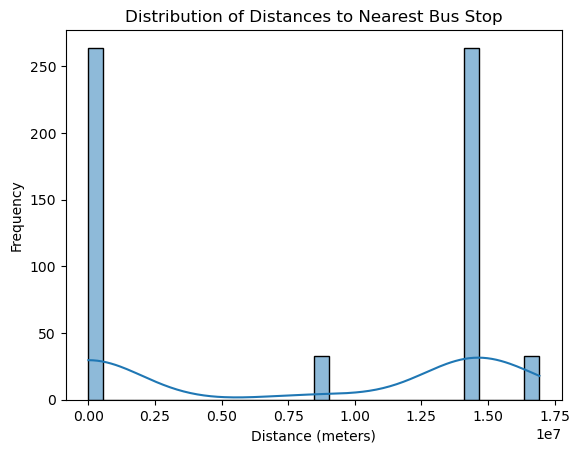

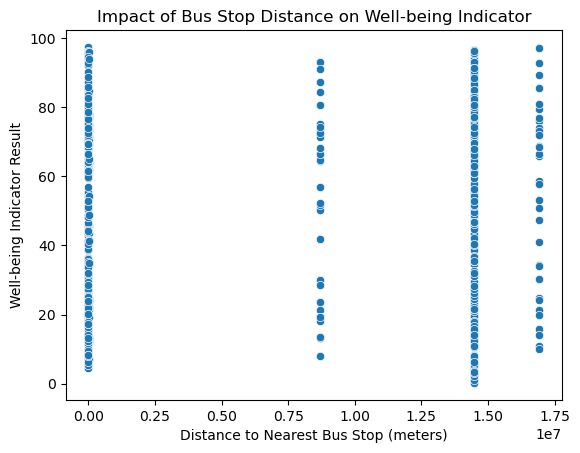

In [61]:


# Histogram of distances to the nearest bus stop
sns.histplot(social_indicators_df['nearest_bus_stop_distance'], bins=30, kde=True)
plt.title('Distribution of Distances to Nearest Bus Stop')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of bus stop distance vs. well-being indicator
sns.scatterplot(x='nearest_bus_stop_distance', y='result', data=social_indicators_df)
plt.title('Impact of Bus Stop Distance on Well-being Indicator')
plt.xlabel('Distance to Nearest Bus Stop (meters)')
plt.ylabel('Well-being Indicator Result')
plt.show()

# Geographical Map Visualization BY LAT,LONG DATA
import folium

# Initialize map centered on Melbourne
melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# AddING respondent locations to the map
for index, row in social_indicators_df.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['location']).add_to(melbourne_map)

# Display map
melbourne_map
